# XGBOOST - TEST

In [1]:
import numpy as np
from sklearn import datasets
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import pandas as pd
from datetime import datetime
from time import time
from sklearn.metrics import balanced_accuracy_score

In [2]:
from sklearn.metrics import roc_auc_score, roc_curve
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [4]:
from sklearn.metrics import confusion_matrix

In [5]:
from sklearn.metrics import accuracy_score

In [6]:
from sklearn.utils.multiclass import unique_labels

In [7]:
from sklearn.metrics import roc_curve, auc

In [52]:
from sklearn.metrics import mean_squared_error

In [47]:
from sklearn.metrics import cohen_kappa_score

### GLOBAL VARIABLES

In [43]:
DATAPATH = 'data/train_test/'
SEED = 47
NITER = 100
CV = 3
SCORE = 'rmse'
handlingnull = False
NJOBS = 2
USEGPU = False
NCLASS = 0

### FUNCTIONS

In [10]:
def plot_roc_curve(true_labels, scores):
    ### actual code for roc + threshold charts start here 
    # compute fpr, tpr, thresholds and roc_auc
    fpr, tpr, thresholds = roc_curve(true_labels, scores)
    roc_auc = auc(fpr, tpr) # compute area under the curve

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    # create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([thresholds[-1],thresholds[0]])
    ax2.set_xlim([fpr[0],fpr[-1]])

    plt.show()
    
    pass

In [11]:
def plot_importance(booster, figsize=(10,5), feature_names=None, **kwargs): 
    
    fig, ax = plt.subplots(1,1,figsize=figsize) 
    
    if feature_names:
        mapper = {'f{0}'.format(i): v for i, v in enumerate(feature_names)}
        mapped = {mapper[k]: v for k, v in booster.get_fscore().items()}
        return xgb.plot_importance(mapped, ax=ax, **kwargs)
    else:
        return xgb.plot_importance(booster=booster, ax=ax, **kwargs)
    pass

In [12]:
def plot_score_dist(y_true, y_score):
    
    df = pd.DataFrame(data=np.column_stack((y_true, y_score)), columns=['target','score'])
    
    plt.figure(figsize=(7, 4))
    ax = sns.boxplot(x="target", y="score", data=df)
    ax.set_title("Score distribution")

    pass

In [13]:
def find_optimal_cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [14]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [classes[c] for c in unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [48]:
def sklearn_qwk(y_true, y_pred) -> np.float64:
    """
    Function for measuring Quadratic Weighted Kappa with scikit-learn
    
    :param y_true: The ground truth labels
    :param y_pred: The predicted labels
    
    :return The Quadratic Weighted Kappa Score (QWK)
    """
    return cohen_kappa_score(y_true, y_pred, weights="quadratic")

### LOAD DATASET

In [15]:
train_features = pd.read_pickle(DATAPATH+'X_train.pkl')

In [17]:
train_labels = pd.read_pickle(DATAPATH+'y_train.pkl')

In [18]:
test_features = pd.read_pickle(DATAPATH+'X_test.pkl')

In [19]:
test_labels = pd.read_pickle(DATAPATH+'y_test.pkl')

In [20]:
train_features.shape

(12383, 89)

In [21]:
test_features.shape

(5307, 89)

In [22]:
### create a DMatrix and handling Null values
if handlingnull:
    #train_features[np.isnan(train_features)] = -9999
    xgtrain = xgb.DMatrix(train_features, train_labels, missing=-9999)
    xgtest = xgb.DMatrix(test_features, missing=-9999)
else:
    xgtrain = xgb.DMatrix(train_features, train_labels)
    xgtest = xgb.DMatrix(test_features)

### TRAIN MODEL

#### Set hyperparameters

In [24]:
# ======== General Parameters ======= #

# Select the type of model to run at each iteration. gbtree or gblinear.
booster = 'gbtree'


# ======== Booster Parameters ======== # 

# Analogous to learning rate in GBM. 
# Typical final values to be used: 0.01-0.2
eta = [0.01] 


# Control the balance of positive and negative weights, useful for unbalanced classes. 
# A typical value to consider: sum(negative instances) / sum(positive instances)scale_pos_weight = 1
scale_pos_weight = int((len(train_labels) - np.sum(train_labels.values))/np.sum(train_labels.values))


# Learning Task Parameters

# This defines the loss function to be minimized. 
# - binary:logistic –logistic regression for binary classification, returns predicted probability (not class)
# - multi:softmax –multiclass classification using the softmax objective, returns predicted class (not probabilities)
#   you also need to set an additional num_class (number of classes) parameter defining the number of unique classes
# - multi:softprob –same as softmax, but returns predicted probability of each data point belonging to each class.
objective  = 'multi:softprob'


# The metric to be used for validation data.
# - rmse – root mean square error
# - mae – mean absolute error
# - logloss – negative log-likelihood
# - error – Binary classification error rate (0.5 threshold)
# - merror – Multiclass classification error rate
# - mlogloss – Multiclass logloss
# - auc: Area under the curve
eval_metric = 'mlogloss'

In [25]:
#model_param = np.load('output/hyperparameters/rseach_xgboost_classifier_bestparams_d2019-11-20.npy').tolist()
model_param = xgb.XGBClassifier().get_xgb_params()

In [26]:
model_param['seed'] = SEED
model_param['booster'] = booster
model_param['objective'] = objective
model_param['n_estimator'] = 500
model_param['scale_pos_weight'] = scale_pos_weight
model_param['nthread'] = 8
model_param['num_class'] = 4

In [28]:
model = xgb.train(model_param, xgtrain, verbose_eval=True)

In [50]:
y_pred = model.predict(xgtest)

In [55]:
y_pred = np.argmax(y_pred, axis=1)

In [56]:
print(SCORE,' : ', mean_squared_error(test_labels,y_pred))

rmse  :  1.7196156020350482


In [57]:
print('QWK : ', sklearn_qwk(test_labels, y_pred))

QWK :  0.4792996603255173


Confusion matrix, without normalization
[[ 682  128    0  459]
 [ 206  134    0  383]
 [  97   65    0  499]
 [ 201   92    0 2361]]


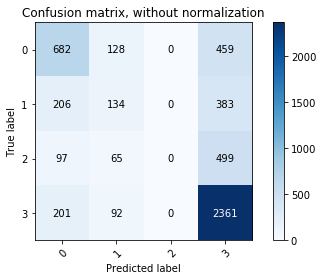

In [58]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(test_labels, y_pred, classes=['0','1','2','3'],
                      title='Confusion matrix, without normalization')

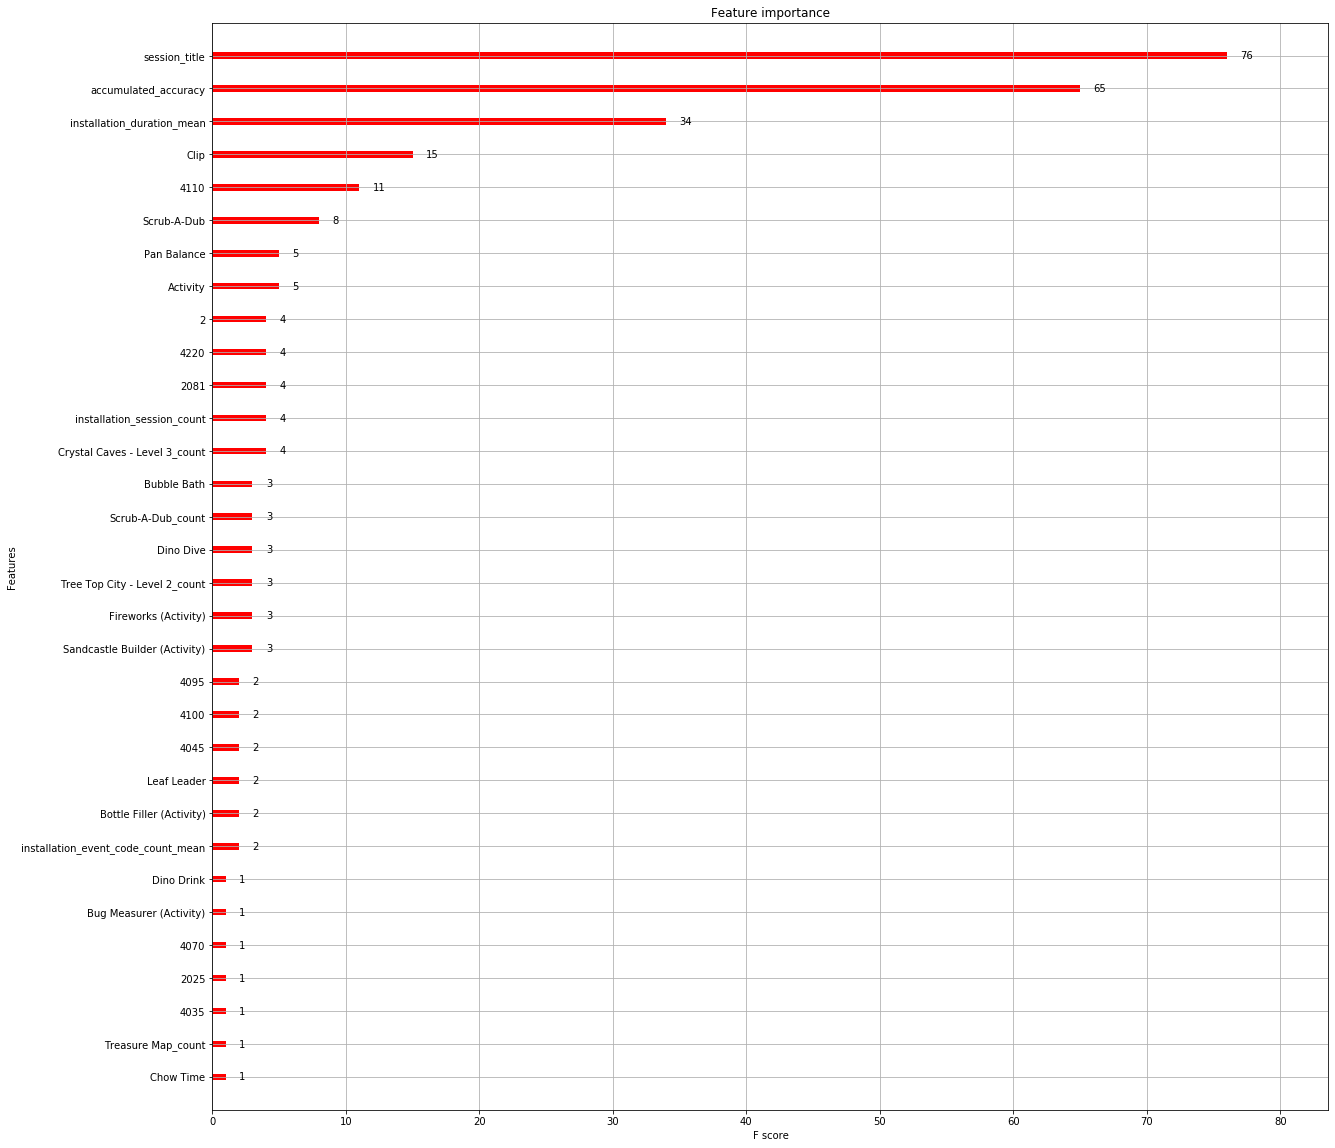

In [59]:
plot_importance(model, figsize=(20,20), feature_names=None, max_num_features=50, color='red')
pass

In [61]:
model.save_model('../models/xgb_002.model')